Lecture notes

0. Challenge
- there is no simple goal
- hard to assess as there is no labeled data and thus CV cannot be performed
- as part of exploratory data analysis

1. PCA
- transform p features into M components
- find normalized principle component loading vector for each M component
    - scale each p feature to have 0 mean
    - first component: find its loading vector that maximize the sample variance
    - other component 1-by-1 in order: find its loading vector maximizing the sample variance and othorgonal to the previous loading vector
- principle component score: defined by using loading vectors and sample, which can be treated as new observation for M components
- Biplot: show score with respect to the first two components, and the first two loading vectors in terms of p features
- principal components provide low-dimensional linear surfaces that are closest to the observations
    - the first component is the line in p-dimensional space that is closest to the n observations
- proportion of variance explained (PVE): to measure how much of the variance in the data is not contained in the first few components
    - scree plot or cumulative PVE
- How many components to use? No simple solution for unsupervised learning
    - typically decide by eyeballing the elbow in the scree plot
    - in practice, if no interesting patterns are found in the first few principal components, then further principal components are unlikely to be of inter- est. Conversely, if the first few principal components are interesting, then we typically continue to look at subsequent principal components until no further interesting patterns are found.
    - for supervised learning, can use CV

2. K-means clustering
- within-cluster variation (WCV): a measure of the amount of difference between observations within a cluster
    - defined using Euclidean distance
    - sum of all of the distances between the observations in the cluster
    - sum of all of the distances between the observation and the mean in the cluster
- partition the observations into K clusters minimizing the total WCV
- Algorithm
    - Initialize: random assign each observation to one of the K clusters
    - Iterate until nochange on the total WCV: 
        - Compute the centroid (mean) for each of the K clusters (gives the total WCV)
        - Assign each observation to the cluster whose centroid is closest (reduces the total WCV)
- only reach local optimum


3. Hierarchical clustering
- Algorithm
    - Initialize: treat each observation as its own cluster (i.e. n clusters at the beginning)
    - Iterate until there is one cluster
        - Compute the dissimilarities for all pairs of clusters
        - Fuse two clusters with least dissimilarity into a new cluster
- linkage for computing the dissimilarity: complete, single, average, centroid
    - need determine the measure used for computing linkage. 
        
4. Practical issues in clustering
- standardize observations or features first?
- what dissimilarity measure?
- what linkage?
- what K?


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import findspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, DataFrame, DataFrameReader
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorSlicer, StandardScaler, PCA
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,LinearSVC, OneVsRest
import itertools
from pyspark.sql.functions import col, when
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans, BisectingKMeans

import graphviz
import os

%matplotlib inline

# change the path on your machine
findspark.init("/Users/lhd0430/Downloads/spark")


In [2]:
# Creat spark session
spark = SparkSession.builder \
   .master("local") \
   .appName("Linear Regression Model") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()

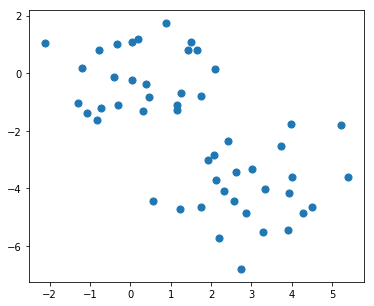

In [20]:
# Prepare data

np.random.seed(123)
X = np.random.randn(50,2)
X[0:25, 0] = X[0:25, 0] + 3
X[0:25, 1] = X[0:25, 1] - 4

plt.figure(figsize=(6, 5))
plt.scatter(X[:,0], X[:,1], s=50) 

df = pd.DataFrame(X, columns=["x1","x2"])
train = spark.createDataFrame(df)
vecAssembler = VectorAssembler(inputCols=train.columns, outputCol="features")
train = vecAssembler.transform(train)


99.66252501749241
0.6002446192493092


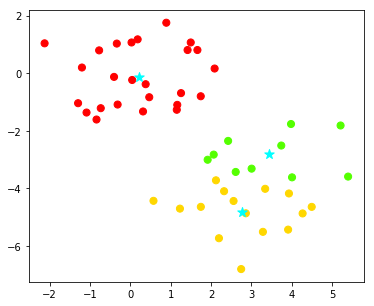

In [74]:
# k-means
# Fit
k = 3
kmeans = KMeans(k=k,seed=2)
ml = kmeans.fit(train)
# Predict
predict = ml.transform(train)
# Evaluate
cost = ml.computeCost(train)
print(cost)
eva = ClusteringEvaluator()
silhouette = eva.evaluate(predict)
print(silhouette)
# plot
predictpddf = predict.toPandas()
plt.figure(figsize=(6,5))
plt.scatter(np.array(predictpddf.x1), np.array(predictpddf.x2), s = 50, c = np.array(predictpddf.prediction),cmap=plt.cm.prism)
plt.scatter(np.array(ml.clusterCenters())[:,0],np.array(ml.clusterCenters())[:,1],s=100,c='cyan',marker='*')

105.29323163986544
0.5987144451459671


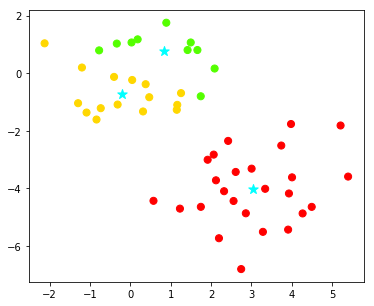

In [75]:
# Hierarchical clustering - sklearn

# Fit
k = 3
bkmeans = BisectingKMeans(k=k,seed=2)
ml = bkmeans.fit(train)
# Predict
predict = ml.transform(train)
# Evaluate
cost = ml.computeCost(train)
print(cost)
eva = ClusteringEvaluator()
silhouette = eva.evaluate(predict)
print(silhouette)
# plot
predictpddf = predict.toPandas()
plt.figure(figsize=(6,5))
plt.scatter(np.array(predictpddf.x1), np.array(predictpddf.x2), s = 50, c = np.array(predictpddf.prediction),cmap=plt.cm.prism)
plt.scatter(np.array(ml.clusterCenters())[:,0],np.array(ml.clusterCenters())[:,1],s=100,c='cyan',marker='*')

In [76]:
spark.stop()